In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import trompy as tp

import dill

%run "..//src//plots_for_spectral"

DATAFOLDER = Path("..//data")
RESULTSFOLDER = Path("..//results")

In [3]:
with open(DATAFOLDER / "snips_data_selected_conditions.pickle", "rb") as f:
    data = dill.load(f)

snips_10NaCl = data["snips_10NaCl_selected"]
snips_45NaCl = data["snips_45NaCl_selected"]
x_10NaCl = data["x_10NaCl_selected"]
x_45NaCl = data["x_45NaCl_selected"]

In [5]:
framerate = 10
pre_window_size = 5 * framerate # frames before infusion
window_size = 200 # Total number of frames plotted around an infusion
frames_for_infusion = 10 * framerate # 10 seconds until end of infusion

populationdata = np.vstack((snips_10NaCl, snips_45NaCl))
sortwindow = [pre_window_size, pre_window_size + frames_for_infusion] # Sort responses between CS+ onset and reward.
sortresponse = np.argsort(np.mean(populationdata[:,sortwindow[0]:sortwindow[1]], axis=1))[::-1]
# sortresponse corresponds to an ordering of the neurons based on their average response in the sortwindow

cmax = 0.1 # Maximum colormap value. 

trial_types = ['trials']

C:\Users\jmc010\AppData\Local\Temp\ipykernel_16088\2375587557.py:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


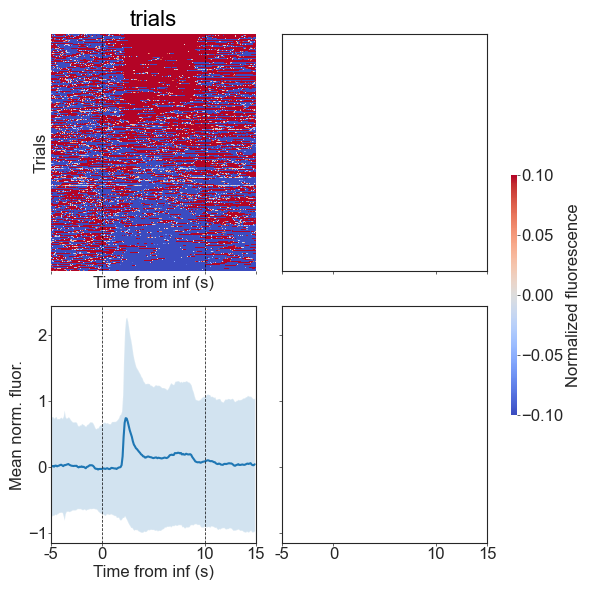

In [6]:

fig, axs = plt.subplots(2,2,figsize=(3*2,3*2), sharex='all', sharey='row')
cbar_ax = fig.add_axes([0.86, .3, .01, .4])
cbar_ax.tick_params(width=0.5) 

for t in range(len(trial_types)):
    axs[0,t].set_title(trial_types[t])
    ax = axs[0,t]
    sns.heatmap(populationdata[sortresponse, t*window_size: (t+1)*window_size],
                ax=ax,
                cmap=plt.get_cmap('coolwarm'),
                vmin=-cmax,
                vmax=cmax,
                cbar=(t==0),
                cbar_ax=cbar_ax if (t==0) else None,
                cbar_kws={'label': 'Normalized fluorescence'})
    ax.grid(False)
    ax.tick_params(width=0.5)   
    ax.set_xticks([0, pre_window_size, pre_window_size + frames_for_infusion, window_size]) 
    ax.set_xticklabels([str(int((a-pre_window_size+0.0)/framerate))
                                     for a in [0, pre_window_size,
                                               pre_window_size + frames_for_infusion, window_size]])
    ax.set_yticks([])
    ax.axvline(pre_window_size, linestyle='--', color='k', linewidth=0.5)    
    ax.axvline(pre_window_size + frames_for_infusion, linestyle='--', color='k', linewidth=0.5)    
    ax.set_xlabel('Time from inf (s)')
    
        
    ax = axs[1,t]
    tsplot(ax, populationdata[sortresponse, t*window_size:(t+1)*window_size],
              )
    ax.axvline(pre_window_size, linestyle='--', color='k', linewidth=0.5)    
    ax.axvline(pre_window_size + frames_for_infusion, linestyle='--', color='k', linewidth=0.5)    
    ax.set_xlabel('Time from inf (s)')
    ax.set_xticks([0, pre_window_size, pre_window_size + frames_for_infusion, window_size]) 
    ax.set_xticklabels([str(int((a-pre_window_size+0.0)/framerate))
                                     for a in [0, pre_window_size,
                                               pre_window_size + frames_for_infusion, window_size]])
    
axs[0,0].set_ylabel('Trials')
axs[1,0].set_ylabel('Mean norm. fluor.')

fig.tight_layout()
fig.subplots_adjust(right=0.82)

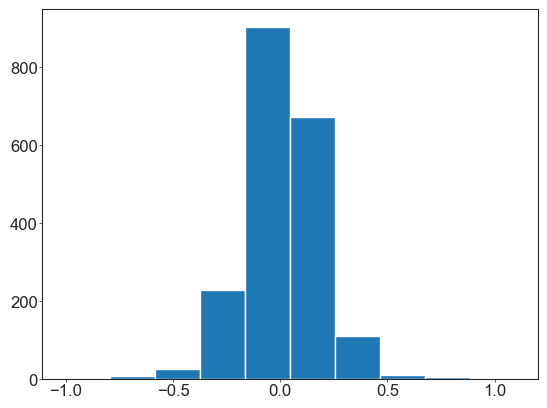

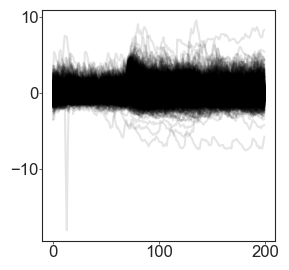

In [7]:
plt.hist(np.mean(populationdata[:,:49], axis=1))

f, ax = plt.subplots(1,1, figsize=(3,3))
for snip in populationdata:
    ax.plot(snip, color='k', alpha=0.1)

Number of PCs = 200
Number of PCs to keep = 10
trials
trials
trials
trials
trials
trials
trials
trials
trials
trials


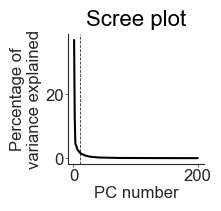

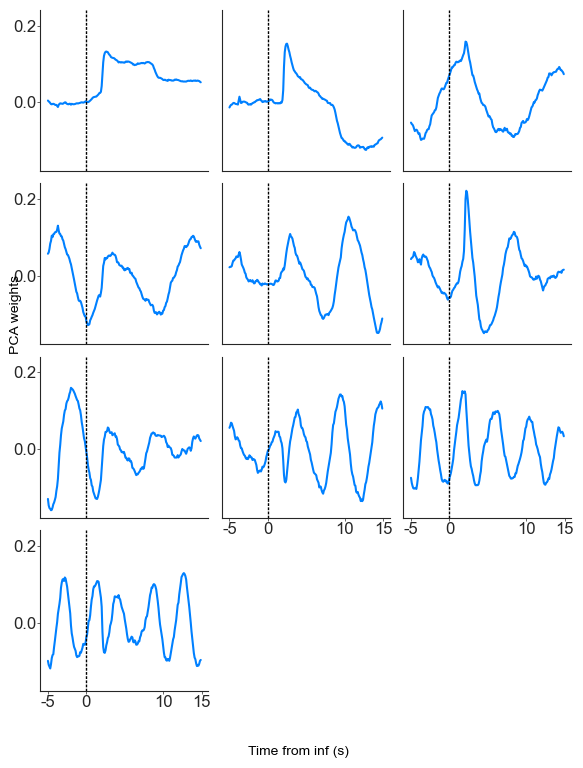

In [10]:
load_savedpca_or_dopca = 'dopca'
# Select 'dopca' for doing PCA on the data. Select 'savedpca' for loading my previous results

if load_savedpca_or_dopca == 'dopca':
    pca = PCA(n_components=populationdata.shape[1], whiten=True)
    pca.fit(populationdata) 
    with open(RESULTSFOLDER / 'pcaresults.pickle', 'wb') as f:
        pickle.dump(pca, f)
elif load_savedpca_or_dopca == 'savedpca':
    with open(RESULTSFOLDER / 'pcaresults.pickle', 'rb') as f:
        pca = pickle.load(f)
    
transformed_data = pca.transform(populationdata)
with open(RESULTSFOLDER / 'transformed_data.pickle', 'wb') as f:
        pickle.dump(transformed_data, f)

pca_vectors = pca.components_
print('Number of PCs = %d'%(pca_vectors.shape[0]))

x = 100*pca.explained_variance_ratio_
xprime = x - (x[0] + (x[-1]-x[0])/(x.size-1)*np.arange(x.size))
num_retained_pcs = np.argmin(xprime)
# Number of PCs to be kept is defined as the number at which the 
# scree plot bends. This is done by simply bending the scree plot
# around the line joining (1, variance explained by first PC) and
# (num of PCs, variance explained by the last PC) and finding the 
# number of components just below the minimum of this rotated plot
print('Number of PCs to keep = %d'%(num_retained_pcs))

fig, ax = plt.subplots(figsize=(2,2))
ax.plot(np.arange(pca.explained_variance_ratio_.shape[0]).astype(int)+1, x, 'k')
ax.set_ylabel('Percentage of\nvariance explained')
ax.set_xlabel('PC number')
ax.axvline(num_retained_pcs, linestyle='--', color='k', linewidth=0.5)
ax.set_title('Scree plot')
# ax.set_xlim([0,50])
#[i.set_linewidth(0.5) for i in ax.spines.itervalues()]
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

fig.subplots_adjust(left=0.3)
fig.subplots_adjust(right=0.98)
fig.subplots_adjust(bottom=0.25)
fig.subplots_adjust(top=0.9)

colors_for_key = {}
colors_for_key['trials'] = (0,0.5,1)

numcols = 3.0
fig, axs = plt.subplots(int(np.ceil(num_retained_pcs/numcols)), int(numcols), sharey='all',
                        figsize=(2*numcols, 2*int(np.ceil(num_retained_pcs/numcols))))
for pc in range(num_retained_pcs):
    ax = axs.flat[pc]
    for k, tempkey in enumerate(trial_types):
        print(tempkey)
        ax.plot(pca_vectors[pc, k*window_size:(k+1)*window_size], color=colors_for_key[tempkey],
                label='PC %d: %s'%(pc+1, tempkey))
    ax.axvline(pre_window_size, linestyle='--', color='k', linewidth=1)
    # ax.annotate(s='PC %d'%(pc+1), xy=(0.45, 0.06), xytext=(0.45, 0.06), xycoords='axes fraction',
    #            textcoords='axes fraction', multialignment='center', size='large')
    if pc >= num_retained_pcs-numcols:
        ax.set_xticks([0, pre_window_size,
                       pre_window_size + frames_for_infusion, window_size])
        ax.set_xticklabels([str(int((a-pre_window_size+0.0)/framerate))
                             for a in [0, pre_window_size,
                                       pre_window_size + frames_for_infusion, window_size]])
    else:
        ax.set_xticks([])
        ax.xaxis.set_ticks_position('none')
    if pc%numcols:
        ax.yaxis.set_ticks_position('none')
    # [i.set_linewidth(0.5) for i in ax.spines.itervalues()]
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)


fig.text(0.5, 0.05, 'Time from inf (s)', horizontalalignment='center', rotation='horizontal')
fig.text(0.02, 0.6, 'PCA weights', verticalalignment='center', rotation='vertical')
fig.tight_layout()
for ax in axs.flat[num_retained_pcs:]:
    ax.set_visible(False)

fig.subplots_adjust(wspace=0.08, hspace=0.08)
fig.subplots_adjust(bottom=0.13)

In [46]:
### Best silhouette score was with spectral clustering using a sigmoid and discretize
# 
# max_n_clusters = 9 # Maximum number of clusters expected. I already ran this with up to 20 clusters and know
# that the optimal number is 9. So, I am leaving this at 11. In your data, might be worth increasing this, but
# it will take more time to run.

possible_n_clusters = np.arange(2, max_n_clusters+1) #This requires a minimum of 2 clusters.
# When the data contain no clusters at all, it will be quite visible when inspecting the two obtained clusters, 
# as the responses of the clusters will be quite similar. This will also be visible when plotting the data in
# the reduced dimensionality PC space (done below).


possible_n_nearest_neighbors = np.array([10, 20, 50, 100, 200, 400, 800]) # This should be selected for each dataset
# appropriately. When 4813 neurons are present, the above number of nearest neighbors provides a good sweep of the
# parameter space. But it will need to be changed for other data.
    
silhouette_scores = np.nan*np.ones((possible_n_clusters.size,
                                    possible_n_nearest_neighbors.size))

possible_n_nearest_neighbors = np.array([400])

for n_clustersidx, n_clusters in enumerate(possible_n_clusters):
    for nnidx, nn in enumerate(possible_n_nearest_neighbors):
        model = SpectralClustering(n_clusters=n_clusters,
                                   affinity='sigmoid',
                                   n_neighbors=nn,
                                   assign_labels='discretize',
                                   random_state=0)
        model.fit(transformed_data[:,:num_retained_pcs])
        silhouette_scores[n_clustersidx, nnidx] = silhouette_score(transformed_data[:,:num_retained_pcs],
                                                                   model.labels_,
                                                                   metric='cosine')
        print('Done with numclusters = %d, num nearest neighbors = %d: score = %.3f'%(n_clusters,
                                                                                      nn,
                                                                                      silhouette_scores[n_clustersidx,                                                                           
                                                                                                        nnidx]))

print('Done with model fitting')

Done with numclusters = 2, num nearest neighbors = 400: score = 0.162
Done with numclusters = 3, num nearest neighbors = 400: score = 0.142
Done with numclusters = 4, num nearest neighbors = 400: score = 0.134
Done with numclusters = 5, num nearest neighbors = 400: score = 0.127
Done with numclusters = 6, num nearest neighbors = 400: score = 0.127
Done with numclusters = 7, num nearest neighbors = 400: score = 0.125
Done with numclusters = 8, num nearest neighbors = 400: score = 0.130
Done with numclusters = 9, num nearest neighbors = 400: score = 0.136
Done with model fitting


In [27]:
from sklearn.cluster import DBSCAN
max_n_clusters = 5

possible_n_clusters = np.arange(2, max_n_clusters+1)

possible_n_nearest_neighbors = np.array([10, 20, 50, 100, 200, 400, 800]) 
    
silhouette_scores = np.nan*np.ones((possible_n_clusters.size,
                                    possible_n_nearest_neighbors.size))

max_silhouette_score = 0
for eps in np.arange(0.1, 20.0, 5.0):
    for min_samples in np.arange(2, 10):
        model = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')
        model.fit(transformed_data[:,:num_retained_pcs])
        try:
            silhouette_scores = silhouette_score(transformed_data[:,:num_retained_pcs],
                                                model.labels_,
                                                metric='cosine')
        except ValueError:
            print('No clusters found.')

        print('Done with eps = %.1f, min_samples = %d: score = %.3f'%(eps,
                                                                      min_samples,
                                                                      silhouette_scores))
        if silhouette_scores > max_silhouette_score:
            max_silhouette_score = silhouette_scores
            best_eps = eps
            best_min_samples = min_samples
            best_model = model

print('Best eps = %.1f, min_samples = %d: score = %.3f'%(best_eps,
                                                          best_min_samples,
                                                          max_silhouette_score))


# for n_clustersidx, n_clusters in enumerate(possible_n_clusters):
#     for nnidx, nn in enumerate(possible_n_nearest_neighbors):
#         model = DBSCAN(eps=0.5, min_samples=nn, metric='euclidean')
#         model.fit(transformed_data[:,:num_retained_pcs])
#         silhouette_scores[n_clustersidx, nnidx] = silhouette_score(transformed_data[:,:num_retained_pcs],
#                                                                    model.labels_,
#                                                                    metric='cosine')
#         print('Done with numclusters = %d, num nearest neighbors = %d: score = %.3f'%(n_clusters,
#                                                                                       nn,
#                                                                                       silhouette_scores[n_clustersidx,                                                                           
#                                                                                                         nnidx]))

print('Done with model fitting')

Done with eps = 0.1, min_samples = 2: score = -0.073
Done with eps = 0.1, min_samples = 3: score = -0.073
Done with eps = 0.1, min_samples = 4: score = -0.073
Done with eps = 0.1, min_samples = 5: score = -0.073
Done with eps = 0.1, min_samples = 6: score = -0.073
Done with eps = 0.1, min_samples = 7: score = -0.073
No clusters found.
Done with eps = 0.1, min_samples = 8: score = -0.073
No clusters found.
Done with eps = 0.1, min_samples = 9: score = -0.073
Done with eps = 5.1, min_samples = 2: score = -0.007
Done with eps = 5.1, min_samples = 3: score = -0.007
Done with eps = 5.1, min_samples = 4: score = -0.007
Done with eps = 5.1, min_samples = 5: score = -0.007
Done with eps = 5.1, min_samples = 6: score = -0.007
Done with eps = 5.1, min_samples = 7: score = -0.007
Done with eps = 5.1, min_samples = 8: score = -0.007
Done with eps = 5.1, min_samples = 9: score = -0.007
No clusters found.
Done with eps = 10.1, min_samples = 2: score = -0.007
No clusters found.
Done with eps = 10.1, 

In [30]:
from sklearn.cluster import KMeans
max_n_clusters = 9

possible_n_clusters = np.arange(2, max_n_clusters+1)

possible_n_nearest_neighbors = np.array([10, 20, 50, 100, 200, 400, 800]) 
    
silhouette_scores = np.nan*np.ones((possible_n_clusters.size,
                                    possible_n_nearest_neighbors.size))

max_silhouette_score = 0
for n_clustersidx, n_clusters in enumerate(possible_n_clusters):
    model = KMeans(n_clusters=n_clusters, n_init=20, max_iter=1000, algorithm='elkan')
    model.fit(transformed_data[:,:num_retained_pcs])
    try:
        silhouette_scores = silhouette_score(transformed_data[:,:num_retained_pcs],
                                            model.labels_,
                                            metric='cosine')
    except ValueError:
        print('No clusters found.')

    print('Done with cluster = %.1f, score = %.3f'%(n_clusters,
                                                                        silhouette_scores))
    if silhouette_scores > max_silhouette_score:
        max_silhouette_score = silhouette_scores
        best_eps = eps
        best_min_samples = min_samples
        best_model = model

print('Best eps = %.1f, min_samples = %d: score = %.3f'%(best_eps,
                                                          best_min_samples,
                                                          max_silhouette_score))


# for n_clustersidx, n_clusters in enumerate(possible_n_clusters):
#     for nnidx, nn in enumerate(possible_n_nearest_neighbors):
#         model = DBSCAN(eps=0.5, min_samples=nn, metric='euclidean')
#         model.fit(transformed_data[:,:num_retained_pcs])
#         silhouette_scores[n_clustersidx, nnidx] = silhouette_score(transformed_data[:,:num_retained_pcs],
#                                                                    model.labels_,
#                                                                    metric='cosine')
#         print('Done with numclusters = %d, num nearest neighbors = %d: score = %.3f'%(n_clusters,
#                                                                                       nn,
#                                                                                       silhouette_scores[n_clustersidx,                                                                           
#                                                                                                         nnidx]))

print('Done with model fitting')

Done with cluster = 2.0, score = 0.161
Done with cluster = 3.0, score = 0.142
Done with cluster = 4.0, score = 0.137
Done with cluster = 5.0, score = 0.136
Done with cluster = 6.0, score = 0.131
Done with cluster = 7.0, score = 0.136
Done with cluster = 8.0, score = 0.138
Done with cluster = 9.0, score = 0.131
Best eps = 15.1, min_samples = 9: score = 0.161
Done with model fitting


In [24]:
temp = {}
temp['possible_n_clusters'] = possible_n_clusters
temp['possible_n_nearest_neighbors'] = possible_n_nearest_neighbors
temp['silhouette_scores'] = silhouette_scores
temp['shape'] = 'cluster_nn'
with open(RESULTSFOLDER / 'silhouette_scores.pickle', 'wb') as f:
    pickle.dump(temp, f)

In [47]:
# with open(RESULTSFOLDER / 'silhouette_scores.pickle', 'rb') as f:
#     silhouette_scores = pickle.load(f)
    
# transformed_data = np.load(os.path.join(ROOT_FOLDER, 'transformed_data.npy'))

# Redo clustering with these optimal parameters
model = SpectralClustering(n_clusters=2,
                           affinity='sigmoid',
                           assign_labels='discretize',)

# model = KMeans(n_clusters=n_clusters)

# model = AgglomerativeClustering(n_clusters=9,
#                                 affinity='l1',
#                                 linkage='average')

model.fit(transformed_data[:,:num_retained_pcs])

temp = silhouette_score(transformed_data[:,:num_retained_pcs], model.labels_, metric='cosine')

print('Number of clusters = %d, average silhouette = %.3f'%(len(set(model.labels_)), temp))

# Save this optimal clustering model.
# with open(os.path.join(basedir, 'clusteringmodel.pickle'), 'wb') as f:
#     pickle.dump(model, f)

          
# Since the clustering labels are arbitrary, I rename the clusters so that the first cluster will have the most
# positive response and the last cluster will have the most negative response.
def reorder_clusters(rawlabels):
    uniquelabels = list(set(rawlabels))
    responses = np.nan*np.ones((len(uniquelabels),))
    for l, label in enumerate(uniquelabels):
        responses[l] = np.mean(populationdata[rawlabels==label, pre_window_size:2*pre_window_size])
    temp = np.argsort(responses).astype(int)[::-1]
    temp = np.array([np.where(temp==a)[0][0] for a in uniquelabels])
    outputlabels = np.array([temp[a] for a in list(np.digitize(rawlabels, uniquelabels)-1)])
    return outputlabels
newlabels = reorder_clusters(model.labels_)

# Create a new variable containing all unique cluster labels
uniquelabels = list(set(newlabels))

np.save(RESULTSFOLDER / 'clusterlabels.npy', newlabels)

colors_for_cluster = [[0.933, 0.250, 0.211],
                      "green",
                      [0.941, 0.352, 0.156],
                      [0.964, 0.572, 0.117],
                      [0.980, 0.686, 0.250],
                      [0.545, 0.772, 0.247],
                      [0.215, 0.701, 0.290],
                      [0, 0.576, 0.270],
                      [0, 0.650, 0.611],
                      [0.145, 0.662, 0.878]]

Number of clusters = 2, average silhouette = 0.162


In [48]:
def make_silhouette_plot(X, cluster_labels):
    
    n_clusters = len(set(cluster_labels))
    
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(4, 4)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax.set_xlim([-0.4, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    silhouette_avg = silhouette_score(X, cluster_labels, metric='cosine')

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels, metric='cosine')

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = colors_for_cluster[i]
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.9)

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i+1))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax.set_title("The silhouette plot for the various clusters.")
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])

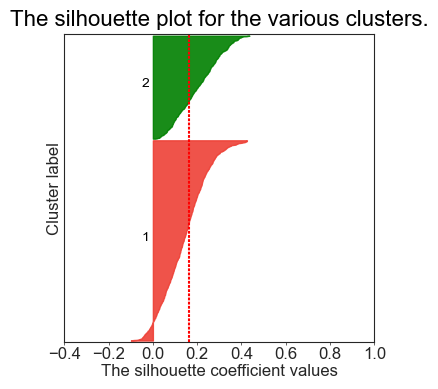

In [49]:
make_silhouette_plot(transformed_data[:,:num_retained_pcs], model.labels_)

C:\Users\jmc010\AppData\Local\Temp\ipykernel_16088\3072839891.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


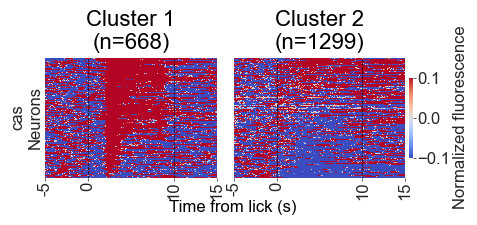

In [50]:
cmax = 0.1
sortwindow = [50, 100]

fig, axs = plt.subplots(len(trial_types),len(uniquelabels),
                        figsize=(2*len(uniquelabels),2*len(trial_types)),
                        gridspec_kw={"top": 0.8})

cbar_ax = fig.add_axes([.94, .3, .01, .4])
cbar_ax.tick_params(width=0.5) 

numroisincluster = np.nan*np.ones((len(uniquelabels),))
for c, cluster in enumerate(uniquelabels):
    k=0
    tempkey='cas'
    temp = populationdata[np.where(newlabels==cluster)[0], k*window_size:(k+1)*window_size]
    numroisincluster[c] = temp.shape[0]
    sortresponse = np.argsort(np.mean(temp[:,sortwindow[0]:sortwindow[1]], axis=1))[::-1]
    sns.heatmap(temp[sortresponse],
                ax=axs[cluster],
                cmap=plt.get_cmap('coolwarm'),
                vmin=-cmax,
                vmax=cmax,
                cbar=(cluster==0),
                cbar_ax=cbar_ax if (cluster==0) else None,
                cbar_kws={'label': 'Normalized fluorescence'})
    axs[cluster].grid(False)
    
    if k==len(trial_types)-1:
        axs[cluster].set_xticks([0, pre_window_size,
                                    pre_window_size + frames_for_infusion, window_size])
    else:
        axs[cluster].set_xticks([])
    axs[cluster].tick_params(width=0.5)    
    axs[cluster].set_xticklabels([str(int((a-pre_window_size+0.0)/framerate))
                                     for a in [0, pre_window_size,
                                               pre_window_size + frames_for_infusion, window_size]])
    axs[cluster].set_yticks([])
    axs[cluster].axvline(pre_window_size, linestyle='--', color='k', linewidth=0.5)
    axs[cluster].axvline(pre_window_size + frames_for_infusion, linestyle='--', color='k', linewidth=0.5)
    if cluster==0:
        axs[0].set_ylabel('%s\nNeurons'%(tempkey))
    axs[cluster].set_title('Cluster %d\n(n=%d)'%(cluster+1, numroisincluster[c]))

fig.text(0.5, 0.05, 'Time from lick (s)', fontsize=12,
         horizontalalignment='center', verticalalignment='center', rotation='horizontal')
fig.tight_layout()

fig.subplots_adjust(wspace=0.1, hspace=0.1)
fig.subplots_adjust(left=0.03)
fig.subplots_adjust(right=0.93)
fig.subplots_adjust(bottom=0.2)
fig.subplots_adjust(top=0.83)

fig.savefig(RESULTSFOLDER / "heatplots_clusters.png")

(668, 200)
(1299, 200)


C:\Users\jmc010\AppData\Local\Temp\ipykernel_16088\3795241839.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
C:\Users\jmc010\AppData\Local\Temp\ipykernel_16088\3795241839.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


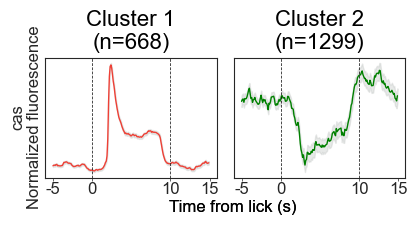

In [51]:
cmax = 0.1
sortwindow = [15, 100]

fig, axs = plt.subplots(len(trial_types),len(uniquelabels),
                        figsize=(2*len(uniquelabels),2*len(trial_types)),
                        gridspec_kw={"top": 0.8})

numroisincluster = np.nan*np.ones((len(uniquelabels),))
for c, cluster in enumerate(uniquelabels):
    k=0
    tempkey='cas'
    temp = populationdata[np.where(newlabels==cluster)[0], k*window_size:(k+1)*window_size]
    numroisincluster[c] = temp.shape[0]
    sortresponse = np.argsort(np.mean(temp[:,sortwindow[0]:sortwindow[1]], axis=1))[::-1]
    
    tp.shadedError(axs[cluster], temp, linecolor=colors_for_cluster[c])
    print(temp.shape)
    
    axs[cluster].grid(False)
    
    if k==len(trial_types)-1:
        axs[cluster].set_xticks([0, pre_window_size,
                                    pre_window_size + frames_for_infusion, window_size])
    else:
        axs[cluster].set_xticks([])
    axs[cluster].tick_params(width=0.5)    
    axs[cluster].set_xticklabels([str(int((a-pre_window_size+0.0)/framerate))
                                     for a in [0, pre_window_size,
                                               pre_window_size + frames_for_infusion, window_size]])
    
    axs[cluster].set_yticks([])
    axs[cluster].axvline(pre_window_size, linestyle='--', color='k', linewidth=0.5)
    axs[cluster].axvline(pre_window_size + frames_for_infusion, linestyle='--', color='k', linewidth=0.5)
    if cluster==0:
        axs[0].set_ylabel('%s\nNormalized fluorescence'%(tempkey))
    axs[cluster].set_title('Cluster %d\n(n=%d)'%(cluster+1, numroisincluster[c]))
    
    fig.text(0.5, 0.05, 'Time from lick (s)', fontsize=12,
         horizontalalignment='center', verticalalignment='center', rotation='horizontal')
    fig.tight_layout()

    fig.subplots_adjust(wspace=0.1, hspace=0.1)
    fig.subplots_adjust(left=0.03)
    fig.subplots_adjust(right=0.93)
    fig.subplots_adjust(bottom=0.2)
    fig.subplots_adjust(top=0.83)
    
fig.savefig(RESULTSFOLDER / "shadederror_clusters.png")

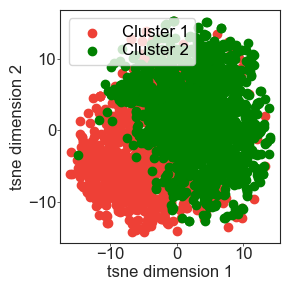

In [52]:
num_clusterpairs = len(uniquelabels)*(len(uniquelabels)-1)/2

numrows = int(np.ceil(num_clusterpairs**0.5))
numcols = int(np.ceil(num_clusterpairs/np.ceil(num_clusterpairs**0.5)))
fig, axs = plt.subplots(numrows, numcols, figsize=(3*numrows, 3*numcols))

tempsum = 0
for c1, cluster1 in enumerate(uniquelabels):
    for c2, cluster2 in enumerate(uniquelabels):
        if cluster1>=cluster2:
            continue
        temp1 = transformed_data[np.where(newlabels==cluster1)[0], :num_retained_pcs]
        temp2 = transformed_data[np.where(newlabels==cluster2)[0], :num_retained_pcs]
        X = np.concatenate((temp1, temp2), axis=0)
        tsne = TSNE(n_components=2, init='random',
                    random_state=0, perplexity=100)
        Y = tsne.fit_transform(X)
        #ax = axs[int(tempsum/numcols),
        #         int(tempsum - tempsum/numcols*numcols)]
        
        try:
            ax = axs.flat[tempsum]
        except:
            ax = axs
        ax.scatter(Y[:np.sum(newlabels==cluster1),0],
                   Y[:np.sum(newlabels==cluster1),1],
                   color=colors_for_cluster[cluster1], label='Cluster %d'%(cluster1+1), alpha=1)
        ax.scatter(Y[np.sum(newlabels==cluster1):,0],
                   Y[np.sum(newlabels==cluster1):,1],
                   color=colors_for_cluster[cluster2], label='Cluster %d'%(cluster2+1), alpha=1)

        ax.set_xlabel('tsne dimension 1')
        ax.set_ylabel('tsne dimension 2')
        ax.legend()
        tempsum += 1
fig.tight_layout()

In [31]:
newlabels

array([0, 0, 0, ..., 1, 1, 1], shape=(1967,))

In [32]:
x_10NaCl = x_10NaCl.assign(infusiontype="10NaCl")
x_45NaCl = x_45NaCl.assign(infusiontype="45NaCl")

x_array = (pd.concat([x_10NaCl, x_45NaCl], axis=0, ignore_index=True)
           .assign(cluster=newlabels)
)

with open(DATAFOLDER / "x_array_with_clusters.pickle", "wb") as f:
    dill.dump(x_array, f)

In [33]:
x_array

,trial,id,condition,infusiontype,cluster
0,0,PB23,deplete,10NaCl,0
1,1,PB23,deplete,10NaCl,0
2,2,PB23,deplete,10NaCl,0
3,3,PB23,deplete,10NaCl,1
4,4,PB23,deplete,10NaCl,0
...,...,...,...,...,...
1962,44,PB75,replete,45NaCl,1
1963,45,PB75,replete,45NaCl,1
1964,46,PB75,replete,45NaCl,1
1965,47,PB75,replete,45NaCl,1


In [55]:
x = x_10NaCl.assign(infusiontype="10NaCl")

In [56]:
x

,trial,id,condition,infusiontype
0,0,PB23,deplete,10NaCl
1,1,PB23,deplete,10NaCl
2,2,PB23,deplete,10NaCl
3,3,PB23,deplete,10NaCl
4,4,PB23,deplete,10NaCl
...,...,...,...,...
44,44,PB33,thirsty,10NaCl
45,45,PB33,thirsty,10NaCl
46,46,PB33,thirsty,10NaCl
47,47,PB33,thirsty,10NaCl


In [31]:
x_array

,trial,id,condition
0,0,PB23,deplete
1,1,PB23,deplete
2,2,PB23,deplete
3,3,PB23,deplete
4,4,PB23,deplete
...,...,...,...
2797,44,PB31,thirsty
2798,45,PB31,thirsty
2799,46,PB31,thirsty
2800,47,PB31,thirsty
